<a href="https://colab.research.google.com/github/Vinicius-GN/VGG16_RoadSegmentation/blob/main/VGG16_RoadSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
''' Road segmentation using a VGG-16 model neral network with KITTI-roadseg dataset'''

import numpy as np
import os
import random
import tensorflow as tf
import cv2
from tqdm import tqdm
import datetime
import time
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.layers import Input, Add, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output

from IPython.display import HTML
from base64 import b64encode
from google.colab.patches import cv2_imshow

In [ ]:
# Defining datasets paths:
#Define your own using the following dataset on the link (https://drive.google.com/drive/folders/1eI30StJqyvsvW7sy9sFn6UfdRcrcxy39?usp=sharing):

training_data = "/content/drive/MyDrive/Datasets/data_road/training/image_2/"
testing_images = "/content/drive/MyDrive/Datasets/data_road/testing/image_2/"

training_groundT = "/content/drive/MyDrive/Datasets/data_road/training/gt_image_2/"

testing_data = "/content/drive/MyDrive/Datasets/KITTI/testing/"

# Getting the number of images of our dataset:
# Training
TRAINING_SIZE = int(len(os.listdir(training_data))*0.85)
print(f"Number of training images from the dataset: {TRAINING_SIZE}")
#85%
DATASET_VALIDATION = int(len(os.listdir(training_data))*0.15)
print(f"Number of validating examples from the dataset: {DATASET_VALIDATION}")
#15%
TEST_IMAGES = int(len(os.listdir(testing_images)))
print(f"Number of Testing Examples: {TEST_IMAGES}")
#Testing_images are in another directory

# Initialize Constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
N_CHANNELS = 3
N_CLASSES = 1 # Here, as we are only interested in binary classification whether it is just a road or not, we only have a single class
SEED = 123 #Seed used in shuffle filter for training dataset

#Define training variables
BATCH_SIZE = 4
BUFFER_SIZE = 1000

# Loading our pre-trained weights of VGG-NET:
model = VGG16()

# Use the following code instead of the above one if you want to load your pre-trained model of other runs.
# model = tf.keras.models.load_model('/content/drive/MyDrive/Pre-trained models/VGG-16/best_model.h5_20240508-013713')
# model.summary()

Number of training images from the dataset: 245
Number of validating examples from the dataset: 43
Number of Testing Examples: 290
553467096/553467096 [==============================] - 3s 0us/step


In [ ]:
# Function to load image and return a dictionary countaining the input image and the corresponding masked image
def parse_image_mask(img_path: str) -> dict:
    #Convertes the image to a tensor of int8bits
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # Three types of img paths on the KITTI road dataset: um, umm, uu
    # gt (Groundtruth) image paths: um_road, umm_road, uu_road -> assigns a mask to the corresponding lane type
    mask_path = tf.strings.regex_replace(img_path, "image_2", "gt_image_2")
    mask_path = tf.strings.regex_replace(mask_path, "um_", "um_road_")
    mask_path = tf.strings.regex_replace(mask_path, "umm_", "umm_road_")
    mask_path = tf.strings.regex_replace(mask_path, "uu_", "uu_road_")

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)

    # Mask colors
    non_road_label = np.array([255, 0, 0])
    road_label = np.array([255, 0, 255])
    other_road_label = np.array([0, 0, 0])

    # Convert to mask to binary mask
    mask = tf.experimental.numpy.all(mask == road_label, axis = 2)
    mask = tf.cast(mask, tf.uint8)
    mask = tf.expand_dims(mask, axis=-1)

    return {'image': image, 'segmentation_mask': mask}

def parse_image(img_path: str) -> dict:
    #Convertes the image to a tensor o int8 bits
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    return {'image': image}

# Generate dataset variables
all_dataset = tf.data.Dataset.list_files(training_data + "*.png", seed=SEED)
all_dataset = all_dataset.map(parse_image_mask) # Decode the images into 2D tensors

test_data = tf.data.Dataset.list_files(testing_images + "*.png", seed=SEED) #Always has the same order
test_data = test_data.map(parse_image)

dataset = all_dataset.take(TRAINING_SIZE + DATASET_VALIDATION)
val_dataset = dataset.skip(TRAINING_SIZE) # Pega 10% do dataset de treino
train_dataset = dataset.take(TRAINING_SIZE) #Pega 90% do dataset de treino
test_dataset = test_data.take(TEST_IMAGES) #Pega dataset de teste

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

245
43
290


In [ ]:
def view_Dataset(display_list, index):
    plt.figure(figsize=(5, 5))

    title = "Input Image"
    for i in range(len(display_list)):
        sample_image = display_list[i]
        plt.title(title)
        plt.imshow(sample_image)
        plt.axis('off')

    plt.savefig(f"outputs/{index}.png")
    plt.show()



Creating new image


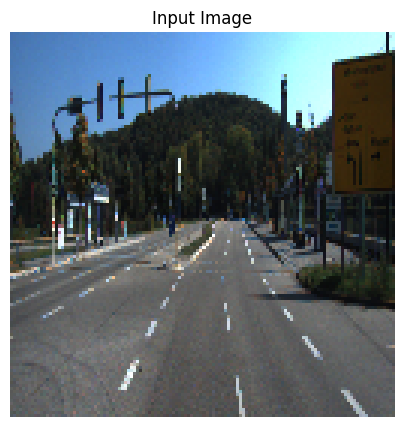

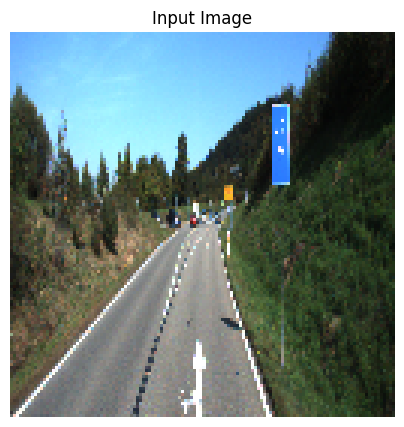

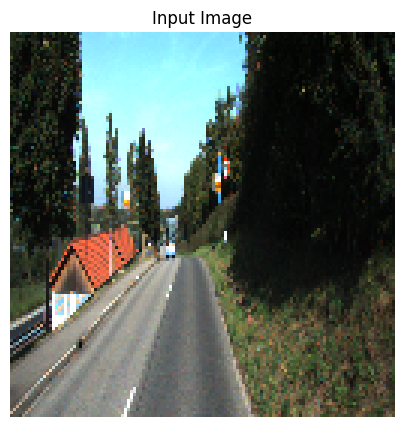

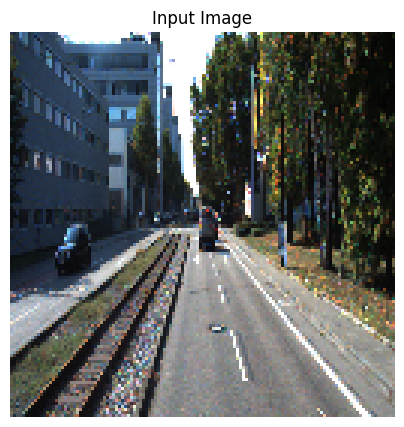

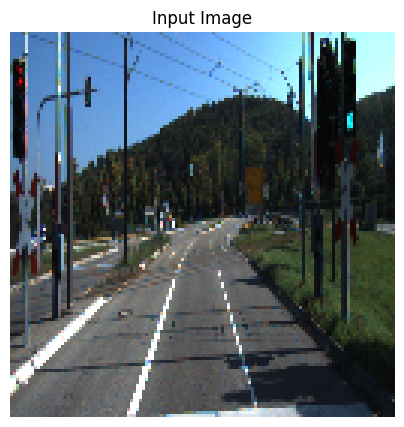

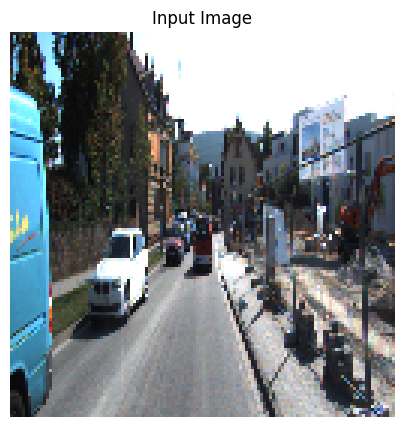

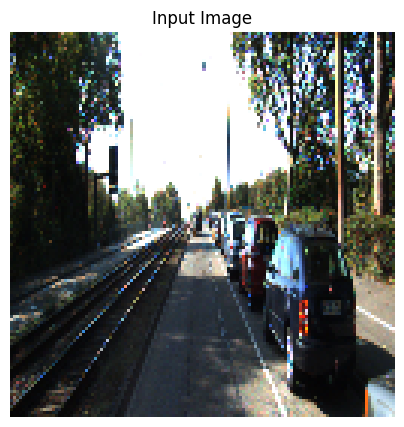

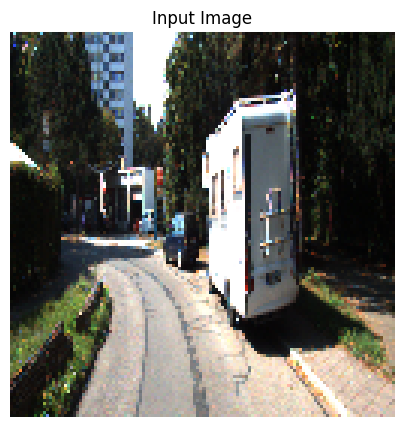

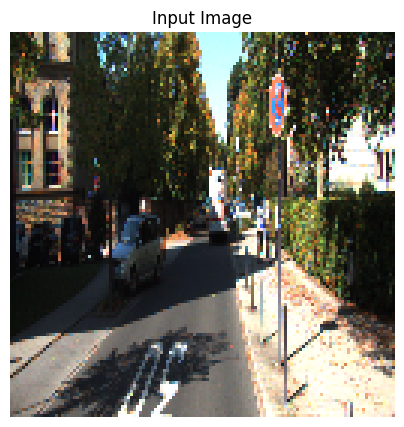

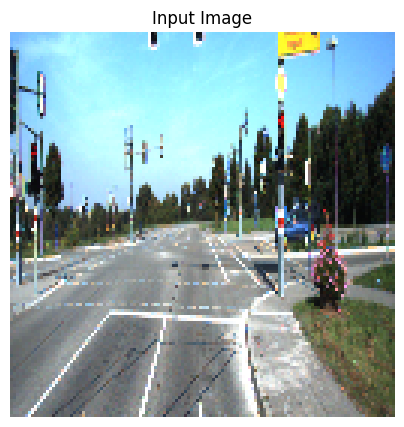

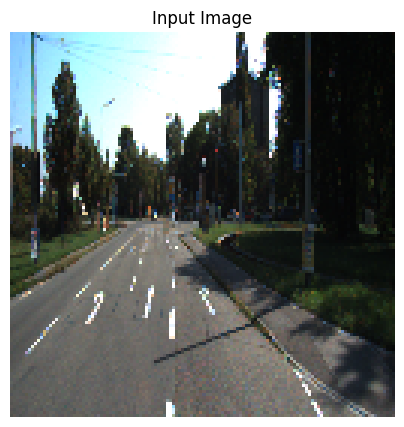

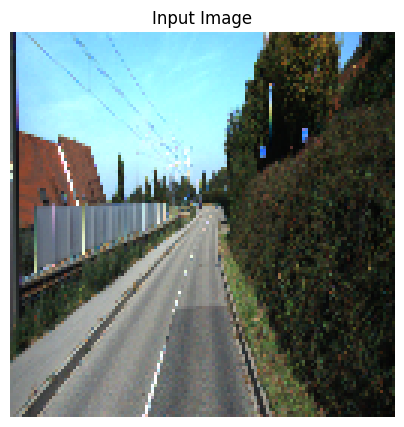

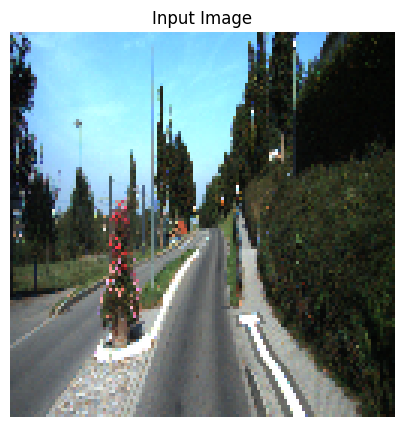

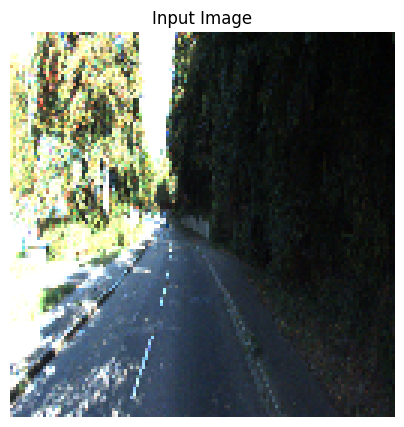

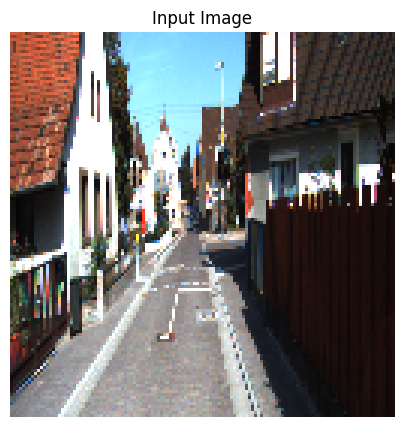

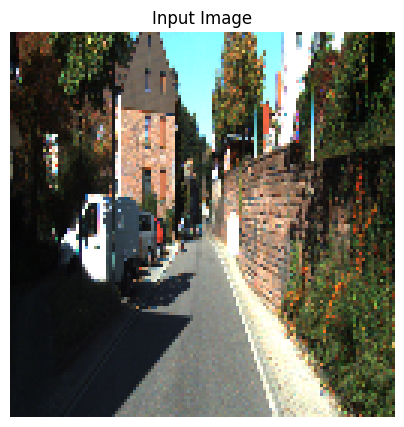

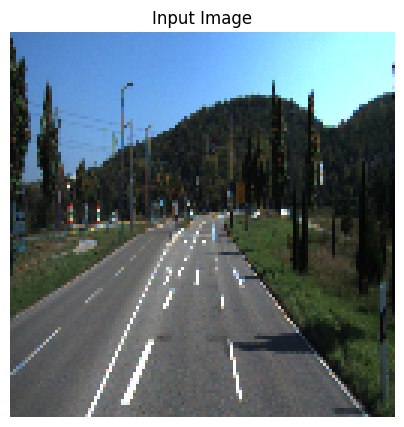

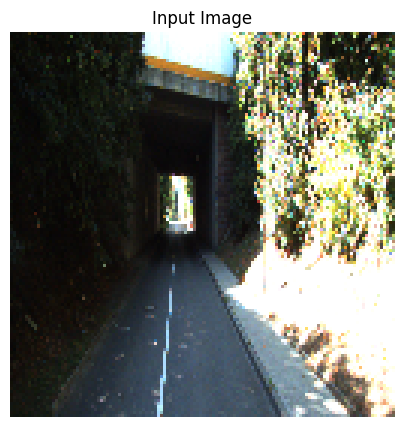

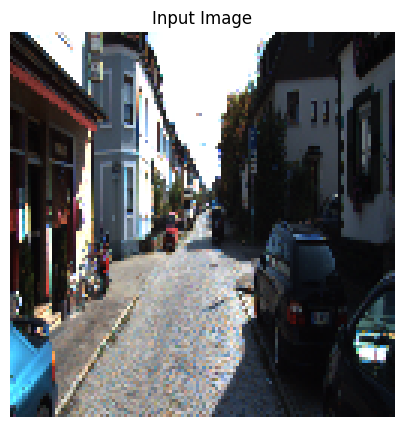

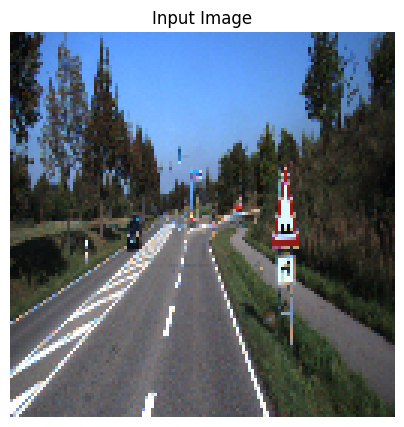

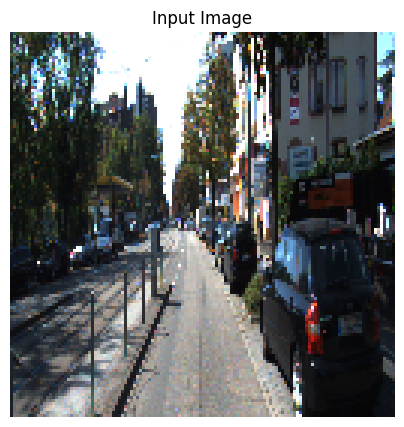

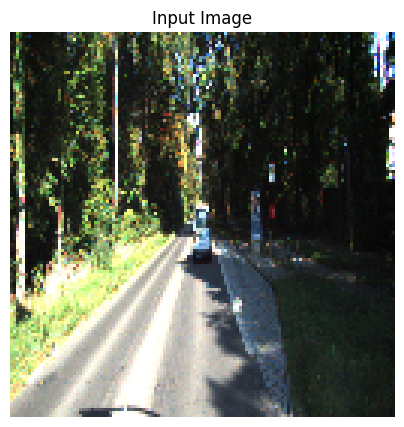

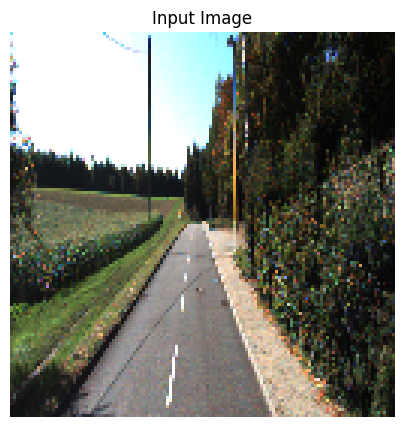

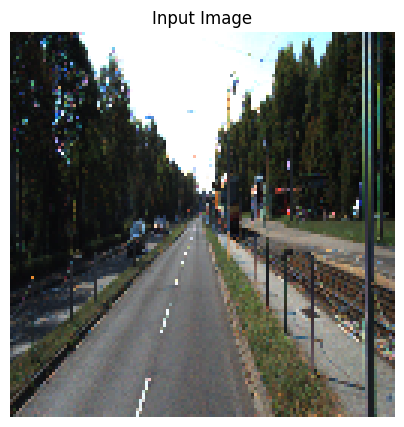

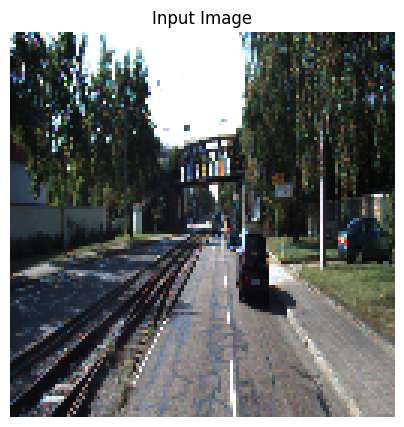

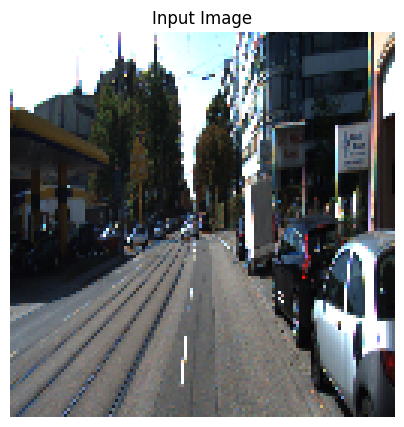

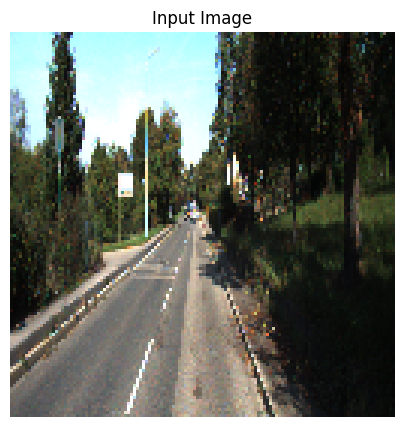

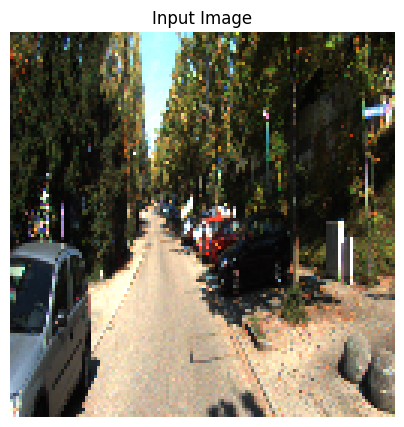

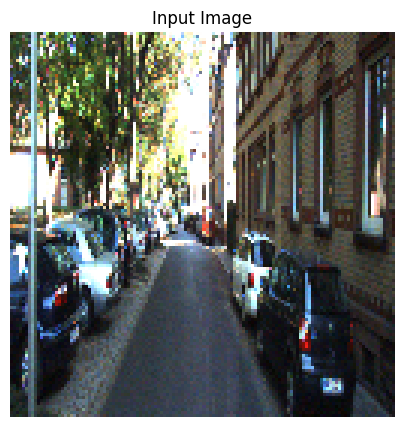

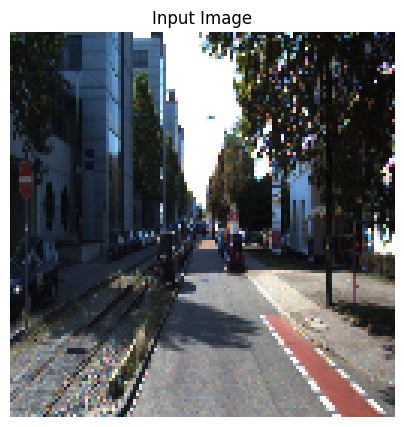

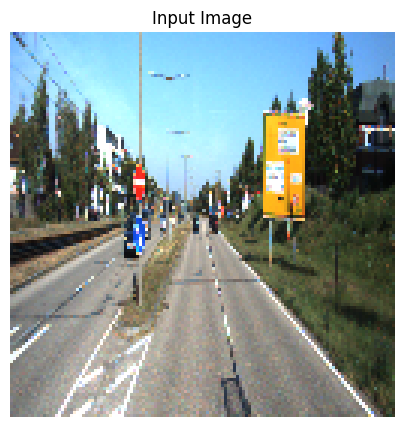

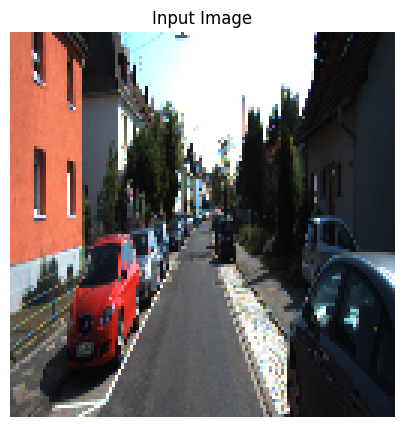

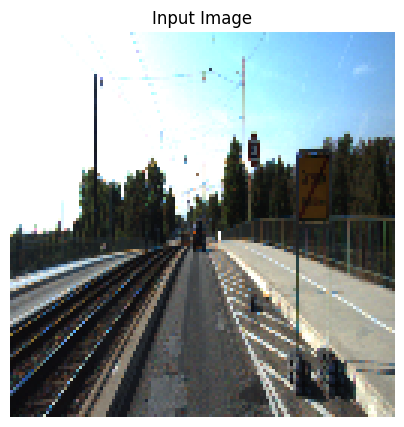

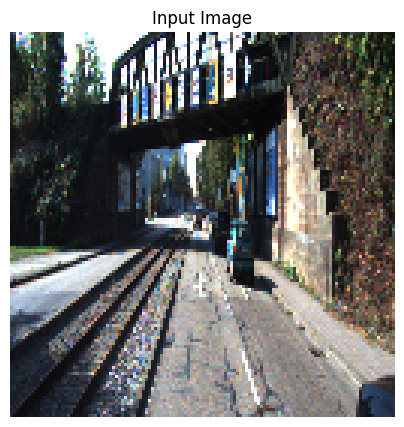

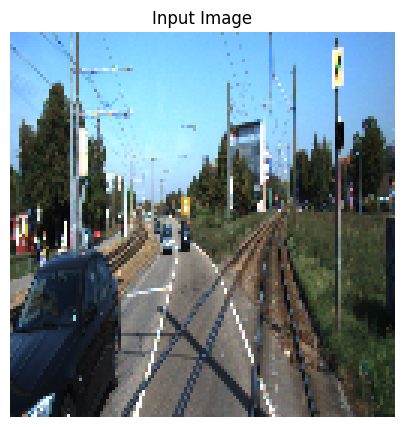

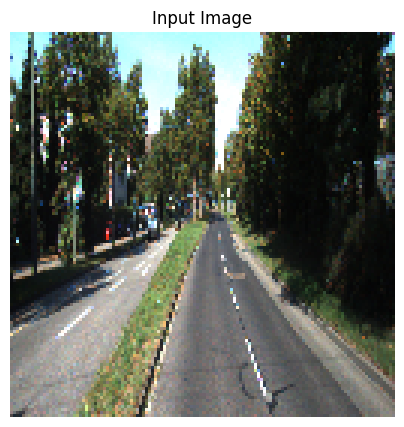

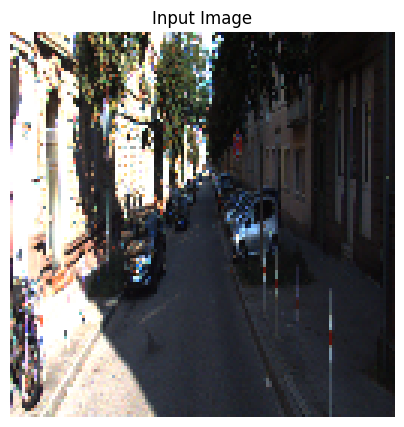

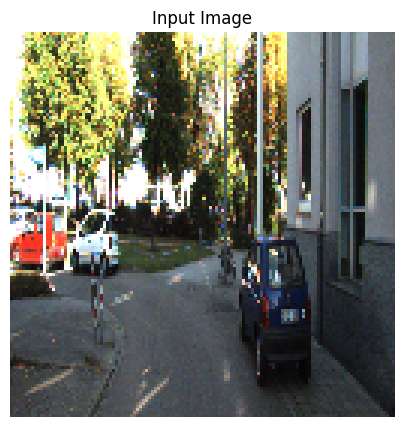

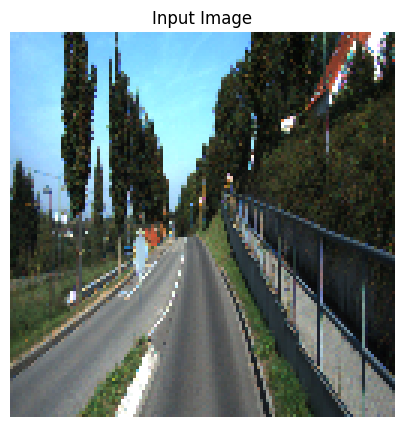

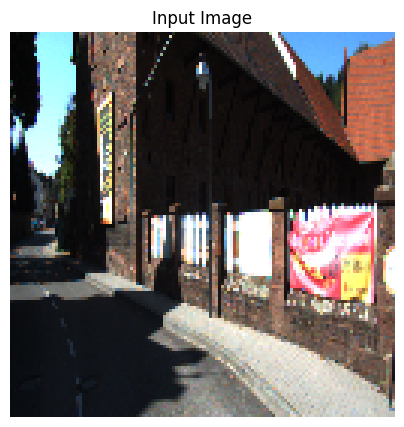

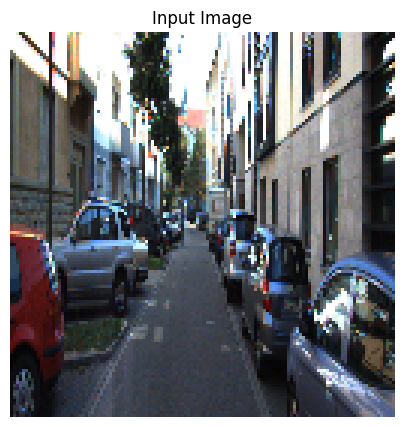

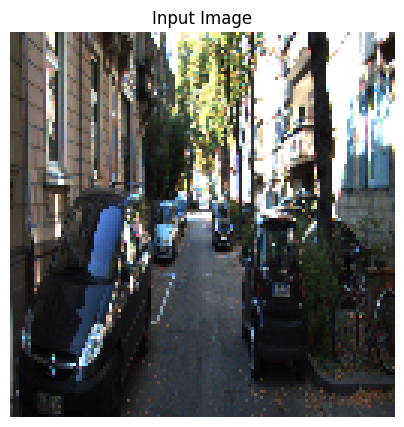

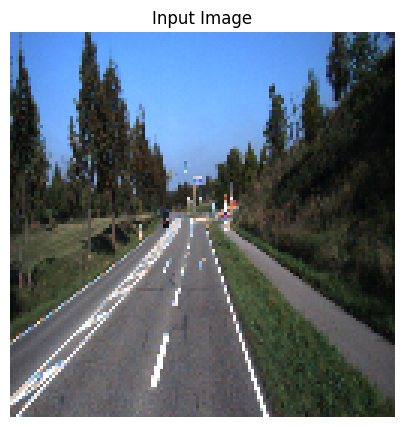

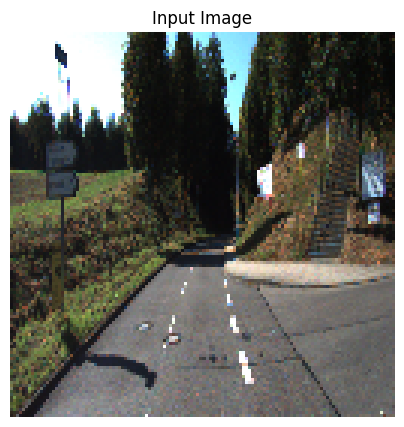

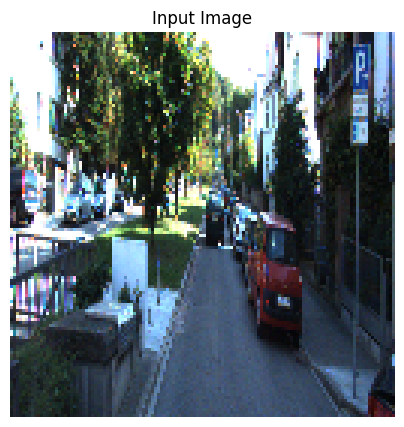

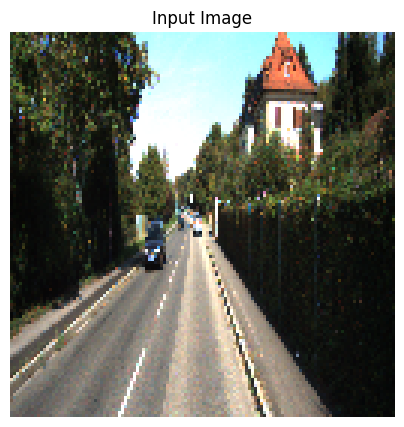

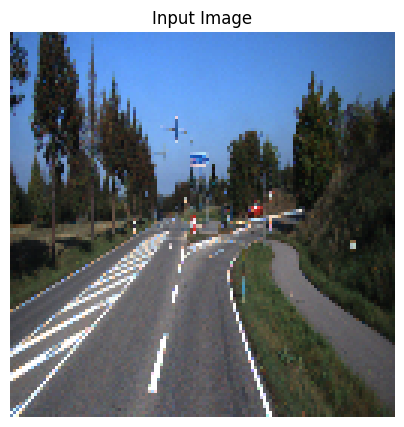

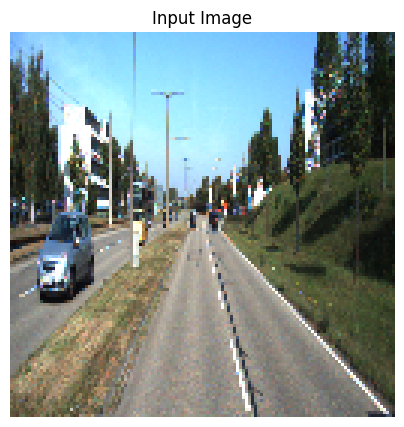

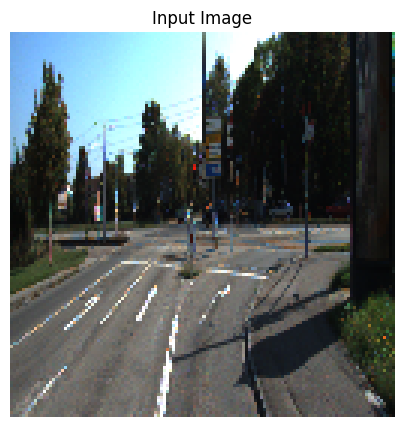

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>


In [ ]:
#Applying transformations:
# Tensorflow function to rescale images to [0, 1] -> PROCESS CALLED BATCH NORMALIZATION
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

# Tensorflow function to apply preprocessing transformations: Image -> Array + batch-Norm
def load_image_train(datapoint: dict) -> tuple:
  #Decrease the images size (make the proccess faster)
    input_image = tf.image.resize(datapoint['image'], (IMG_HEIGHT, IMG_WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_HEIGHT, IMG_WIDTH))

    random = tf.random.uniform(())
    # Here, we are randomly expandding the dataset (data augmentation)
    if random >= 0.5:
      print("Creating new image")
      if random >= 0.55:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
      else:
        input_image = tf.image.adjust_brightness(input_image, 0.4)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Tensorflow function for preprocessing validation images (resize+normalização)
def load_image_val(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_HEIGHT, IMG_WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_HEIGHT, IMG_WIDTH))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

    # Tensorflow function for preprocessing validation images (resize+normalização)
def load_image_test(datapoint: dict):
    input_image = tf.image.resize(datapoint['image'], (IMG_HEIGHT, IMG_WIDTH))

    input_image, _ = normalize(input_image, None)

    return input_image

# Creating a dictionary for storying our dataset variables
dataset = {"train": train_dataset, "val": val_dataset, "test": test_dataset}

#-- Validation Dataset --#
# Assuming dataset['val'] contains all validation data exactly once.
dataset['val'] = dataset['val'].map(load_image_val)
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=tf.data.AUTOTUNE)

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.AUTOTUNE)

#Create a directory for saving the model outputs
os.makedirs("outputs", exist_ok=True)
index = 0

#-- Testing Dataset --#
dataset['test'] = dataset['test'].map(load_image_test)
dataset['test'] = dataset['test'].batch(BATCH_SIZE)
dataset['test'] = dataset['test'].prefetch(buffer_size=tf.data.AUTOTUNE)

#Visualise the test images
for image in dataset['test'].take(TEST_IMAGES):
  view_Dataset(image, index)
  index += 1

# See the expected input shape for each dictionary position
print(dataset['train'])
print(dataset['val'])
print(dataset['test'])

In [ ]:
# Function to view the images from the directory
def display_sample(display_list):
    plt.figure(figsize=(15, 28))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()


In [ ]:
# '''------------ Creating the Model --------------'''

#If you already have your pre-trained models of other runs, please, comment this cell.

INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, N_CHANNELS)
inputs = Input(INPUT_SHAPE)

# Creating our model basead on the VGG-16 model (adding the decoder features):
vgg16_model = VGG16(include_top = False, weights = 'imagenet', input_tensor = inputs) #here, we take off the final layers (after encoding)
vgg16_model.summary()

# Take Pools 3, 4 and 5 for concatenate in the decoder part
c1 = vgg16_model.get_layer("block3_pool").output
c2 = vgg16_model.get_layer("block4_pool").output
c3 = vgg16_model.get_layer("block5_pool").output


# Decoder head (Using U-NET archtecture)
u1 = UpSampling2D((2,2), interpolation = 'bilinear')(c3)
d1 = Concatenate()([u1, c2])

u2 = UpSampling2D((2,2), interpolation = 'bilinear')(d1)
d2 = Concatenate()([u2, c1])

# Output
u3 = UpSampling2D((8,8), interpolation='bilinear')(d2)
outputs = Conv2D(N_CLASSES, 1, activation = 'sigmoid')(u3)

# Creating our definitive model
model = Model(inputs, outputs, name = "VGG_FCN8")

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

1/1 [==============================] - 3s 3s/step


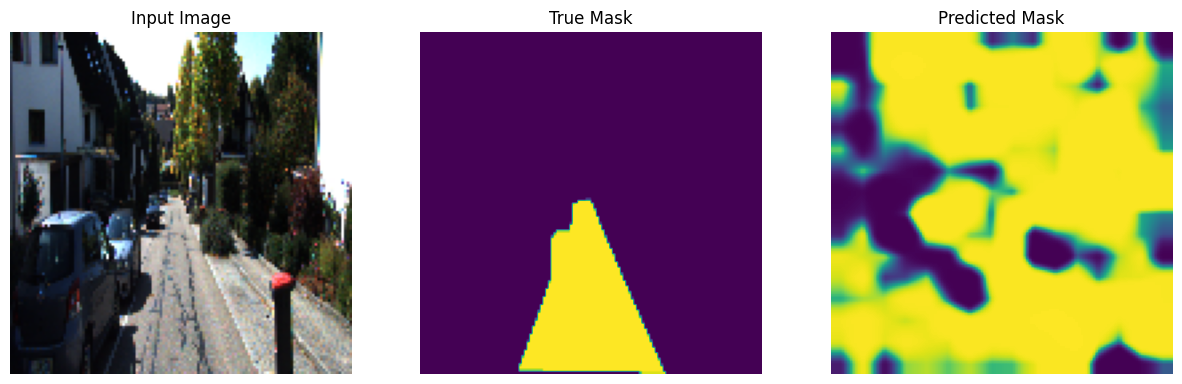

In [ ]:
'''------------ Training Step --------------'''

# Loss function (CE)
m_iou = tf.keras.metrics.MeanIoU(2)
model.compile(optimizer=Adam(),
              loss=BinaryCrossentropy(),
              metrics=[m_iou])

# Function to create a mask out of network prediction
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # Round to closest integer
    pred_mask = tf.math.round(pred_mask)

    # [IMG_SIZE, IMG_SIZE] -> [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

# Function to show predictions
def show_predictions(dataset=None, num=28):
    if dataset:
        # Predict and show image from input dataset
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask)])
    else:
        # Predict and show the sample image
        inference = model.predict(sample_image)
        display_sample([sample_image[0], sample_mask[0],
                        inference[0]])

for sample_image, sample_mask in dataset['train'].take(1):
  show_predictions()

In [ ]:
import zipfile
from google.colab import files

def zip_logs(log_folder='/content/logs', zip_path='/content/logs.zip'):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as z:
        for root, dirs, files in os.walk(log_folder):
            for file in files:
                z.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(log_folder, '..')))

def download_logs(zip_path='/content/logs.zip'):
    files.download(zip_path)


In [ ]:
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        if ((epoch >= 100) and (epoch % 10 == 0)):
            # Compacte e baixe os logs
            zip_logs()
            download_logs()

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
bestdir = "/content/drive/MyDrive/Pre-trained models/VGG-16/"

callbacks = [
    DisplayCallback(),
    callbacks.TensorBoard(logdir, histogram_freq = -1),
    callbacks.ModelCheckpoint(os.path.join(bestdir,f'best_model.h5_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'), verbose = 2)
]

# Set Variables
EPOCHS = 200
STEPS_PER_EPOCH = TRAINING_SIZE // BATCH_SIZE
VALIDATION_STEPS = DATASET_VALIDATION // BATCH_SIZE
print(STEPS_PER_EPOCH)
print(VALIDATION_STEPS)

61
10


In [ ]:

model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data = dataset["val"],
                          validation_steps=VALIDATION_STEPS,
                          callbacks = callbacks)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
model.save('/content/drive/MyDrive/Pre-trained models/my_saved_model')


In [ ]:
#TensorBoard Visualization

%load_ext tensorboard
logdir = "/content/logs/20240507-011909"

In [ ]:
%tensorboard --logdir logs

In [ ]:
# Function to calculate mask over image
def weighted_img(img, initial_img, α=1., β=0.8, γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Function to process an individual image and it's mask
def process_image_mask(image, mask):
    # Round to closest
    mask = tf.math.round(mask)

    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image)) * 255
    mask = np.asarray(mask, np.uint8)

    # Convert to an image
    image = np.asarray(image, np.float32)
    image = (image * 255).astype(np.uint8)

    # Get the final image
    final_image = weighted_img(mask, image)

    return final_image

In [ ]:
# Function to save predictions
def save_predictions(dataset):
    # Predict and save image from the input dataset
    index = 0
    for batch_images in dataset:  # Each item in dataset is a batch of images
        print("Batch image shape:", batch_images.shape)  # Print shape to verify
        for image in batch_images:  # Iterate through each image in the batch
            print("Processing image:", index)
            # No need to use zip, directly use image from the loop
            pred_mask = model.predict(tf.expand_dims(image, axis=0))  # Ensure image is 4D
            processed_img = process_image_mask(image, pred_mask[0])
            resized_img = cv2.resize(processed_img, (1242, 375))

            save_single_sample(resized_img, index)
            index += 1

            if index == 100:  # Exit if processed all required images
                return

            # if index == len(os.listdir(testing_images)):  # Exit if processed all required images
            #     return

# Function to save the images as a plot
def save_sample(display_list, index):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'Predicted Mask', "Image Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.savefig(f"outputs/{index}.png")
    plt.show()

def save_single_sample(image, index):
    #Saving the image in a directory
    # if image.dtype != np.uint8:
    #     image = (image * 255).astype(np.uint8)

    cv2.imwrite(f"outputs/{index}.png", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    #Ploting image using matplotlib
    plt.figure(figsize=(25, 7))

    plt.title("Predicted Mask")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.axis('off')

    plt.show()

In [ ]:


os.makedirs("outputs", exist_ok=True)
save_predictions(dataset['test'])



In [ ]:
#Now, we can also try to implement it in real time using video frames as testing images:

# Function to process an individual image
def process_image(image):
    # Preprocess image
    height, width = 1280, 720
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    # Get the binary mask
    pred_mask = model.predict(np.expand_dims(image, axis = 0))
    mask = np.round_(pred_mask[0])

    # Convert to mask image
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image)) * 255
    mask = np.asarray(mask, np.uint8)

    # Get the final image
    final_image = weighted_img(mask, image)
    final_image = cv2.resize(final_image, (height, width))

    return final_image

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

os.makedirs("videos", exist_ok = True)

In [ ]:
#~~~First way for testing the model on video ~~~

project_video = "challenge_video.mp4"
original_video = cv2.VideoCapture(testing_data + project_video)
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + project_video, fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))

    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

In [ ]:
play("videos/" + project_video)

In [ ]:
#~~~ Second way for testing the model on video ~~~

from IPython.display import clear_output


project_video = "challenge.mp4"
original_video = cv2.VideoCapture(testing_data + project_video)

# where we create the axis plot
plt.figure(figsize=(10, 10))
frames = []
title = ("Video output")

while(original_video.isOpened()):
    ret, frame = original_video.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = process_image(frame)
        plt.title(title)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(frame))
        plt.axis('off')
        frames.append(frame)
        plt.show()


        clear_output(wait=True)

    else:
        break

original_video.release()
plt.close()

In [ ]:
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

clip = ImageSequenceClip(frames, fps=24)
clip.write_videofile(project_video)
